In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

np.random.seed(42)

# Diffusion and Probabilistic Models & Pyro

_Note: The author does not guarantee correctness of below presented results. Treat this notebook as a mere suggestion to the posed tasks for Assignment 6 of the PML 2022/23 course._

## Programming Exercise Diffusion

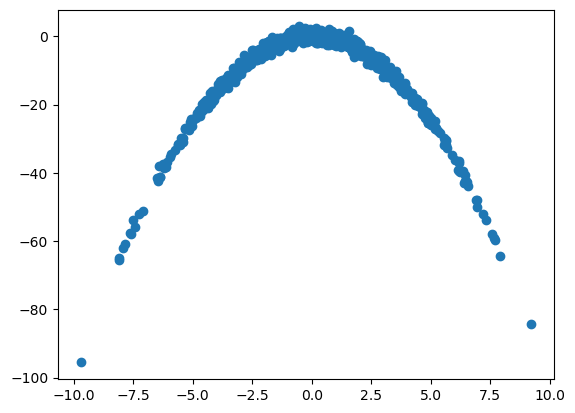

In [2]:
# target distribution q_D
N = 1000
Xs = np.random.randn(2*N).reshape(N,2)
Xs[:,0]*=3
Xs[:,1]+= -Xs[:,0]**2

plt.figure()
plt.scatter(Xs[:,0],Xs[:,1])
plt.show()

In [3]:
#neural network to learn epsilon(x_t,t). you can play around with it, but we added it for convenience

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 32)
        self.fct = nn.Linear(4, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 2)

    def forward(self, x, t):
        # we use a time-embedding here. neural networks are terrible at working directly with time as a real variable.
        # we therefore replace it by a set of features t_embedding that just represent several sine waves with different
        # frequency
        omegas = 2*np.pi*torch.tensor([1.0/T,2.0/T,4.0/T,8.0/T]).reshape(1,-1)
        t_embedding = torch.cos(omegas*t.reshape(-1,1))
        # Network structure: a simple network with two hidden layers. the first
        # two fully connected layers are just there to merge the time embedding with the input vector
        x = F.relu(self.fc1(x)+self.fct(t_embedding))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
def exp_f(x,y): return np.exp(-np.abs(x-y))

betas_b = np.array(list(map(lambda x: exp_f(x[0],x[1]), zip(np.arange(1,101), np.arange(0,100)))))
betas_b[1:10]

array([0.36787944, 0.36787944, 0.36787944, 0.36787944, 0.36787944,
       0.36787944, 0.36787944, 0.36787944, 0.36787944])

In [5]:
def compute_alpha_bar(t): # alternative alpha formulation
    return (1-0.05)**t

In [6]:
# Task 1: for the given set of T and beta plot the generating distribution q(X_t) for different t=0,30,60,100
T=100
betas = 0.05*np.ones(T)
#betas = np.ones(T) - betas_b
alphas = np.exp(np.cumsum(np.log(1-betas))) # c.f. Eq. 70 in script

Text(0.5, 1.0, 'Alphas over t')

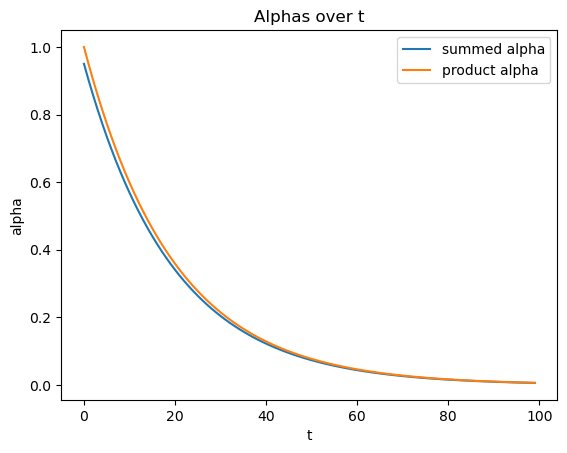

In [7]:
plt.plot(alphas, label="summed alpha")
plt.plot(list(map(compute_alpha_bar, np.arange(0, 100))), label="product alpha")
plt.ylabel("alpha")
plt.xlabel("t")
plt.legend()
plt.title("Alphas over t")

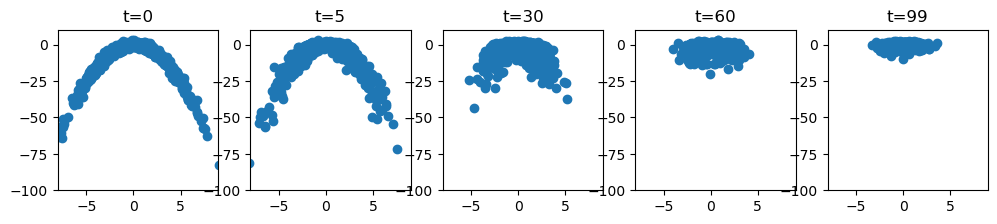

In [23]:
noise_results = []
#alpha_idx = [0, T//20, T//10, T//5, T-1]
ts = [0, T//20, int(T//3.3), int(T//1.65), T-1]
for a in alphas[ts]:
    x_noise = np.sqrt(a)*Xs + np.sqrt(1-a)*np.random.randn(2*N).reshape(N,2)
    noise_results.append(x_noise)

fig, ax = plt.subplots(1, 5, figsize=(12, 6))
for i, res in enumerate(noise_results):
    ax[i].scatter(res[:, 0], res[:, 1])
    ax[i].set_title(f"t={alpha_idx[i]}")
    ax[i].set_box_aspect(1)
    ax[i].set_xlim((-8, 9))
    ax[i].set_ylim((-100, 10))

plt.show()

In [9]:
#Task 2: implement the loss function for gradient descent (eq 76 in th script, or L_simple in the background material)
#implement by sampling a random time step t in 0,..,T
#params: 
#    Xs: a batch of samples from the dataset.
#    model: the model for learning epsilon.

def loss(Xs, model):
    ts = torch.randint(T, size=(Xs.shape[0],)) # pick t uniformly at random
    alpha = torch.tensor(alphas)[ts].reshape(-1,1)
    epsilon = torch.normal(0., 1., size=Xs.shape)
    samples = torch.sqrt(alpha)*Xs + torch.sqrt(1-alpha)*epsilon
    eps_model = model.forward(samples.type(torch.float32), ts)
    loss = torch.sum((epsilon-eps_model)**2)/Xs.shape[0] # Normalization not contained in Eq.76
    # loss = torch.sum(torch.norm(epsilon-eps_model, dim=-1)**2)/Xs.shape[0]
    return loss

In [10]:
#train loop. added for your convenience.
train_loader = torch.utils.data.DataLoader(torch.tensor(Xs,dtype=torch.float32), batch_size=10)
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.train()
num_epochs = 500
losses = []
for e in range(num_epochs):
    if e % (num_epochs//10) == 0:
        print("epoch:",e)
    for data in train_loader:
        optimizer.zero_grad()
        l = loss(data,model) 
        l.backward()
        optimizer.step()
    losses.append(l.item())

epoch: 0
epoch: 50
epoch: 100
epoch: 150
epoch: 200
epoch: 250
epoch: 300
epoch: 350
epoch: 400
epoch: 450


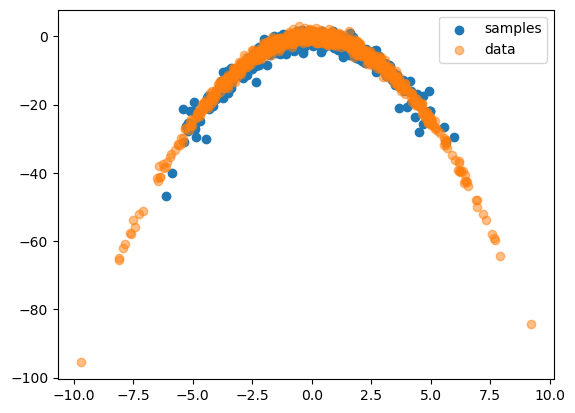

In [11]:
#Task 3: generate samples from the learned model
#num: number of samples to generate
#model: the trained model
def generate_samples(model, num):
    Xs =  torch.normal(0.0,1.0,size=(num,2),dtype=torch.float32)
    for t in reversed(range(T)):
        alpha = torch.tensor(alphas)[t]
        beta = torch.tensor(betas)[t]
        eps_model = model(Xs, t*torch.ones(num))
        std_model = beta / torch.sqrt(1-alpha)
        mu = (Xs-eps_model*std_model)/torch.sqrt(1-beta)
        Xs = mu + torch.normal(0., 1., size=(num, 2)) * torch.sqrt(beta)
    return Xs

samples = generate_samples(model, num=500).detach().numpy()

plt.figure()
plt.scatter(samples[:,0],samples[:,1], label="samples")
plt.scatter(Xs[:,0],Xs[:,1], label="data", alpha=0.5)
plt.legend()
plt.show()

## Programming Exercise Pyro

In [12]:
import arviz
import pyro
#from numpyro.infer.util import Predictive
import pyro.distributions as pdist
import torch.distributions as tdist
import sklearn
from sklearn import datasets
from sklearn import model_selection

In [13]:
## Task 1) Implement the Iris-SVI model with NUTS instead of SVI, and check sample quality with arviz

### Load dataset
Dx=4 # Input vector dim
Dy=3 # Number of labels

iris=datasets.load_iris()
x_all=torch.tensor(iris.data, dtype=torch.float) # Input vector (4D)
y_all=torch.tensor(iris.target, dtype=torch.int) # Label(3 classes)

# Make training and test set
x, x_test, y, y_test = sklearn.model_selection.train_test_split(
    x_all, y_all, test_size=0.33, random_state=42)

print("Data set / test set sizes: %i, %i." % (x.shape[0], x_test.shape[0]))

Data set / test set sizes: 100, 50.


In [14]:
class Model:
    def __init__(self, x_dim=4, y_dim=3, h_dim=5):
        self.x_dim=x_dim
        self.y_dim=y_dim
        self.h_dim=h_dim

    def __call__(self, x, y=None):
        """
        We need None for predictive
        """
        x_dim=self.x_dim
        y_dim=self.y_dim
        h_dim=self.h_dim
        # Number of observations
        n=x.shape[0]
        # standard deviation of Normals
        sd=1 # EXX: 100->1
        # Layer 1
        w1=pyro.sample("w1", pdist.Normal(0, sd).expand([x_dim, h_dim]).to_event(2))
        b1=pyro.sample("b1", pdist.Normal(0, sd).expand([h_dim]).to_event(1))
        # Layer 2 # EXX: added layer
        w2=pyro.sample("w2", pdist.Normal(0, sd).expand([h_dim, h_dim]).to_event(2))
        b2=pyro.sample("b2", pdist.Normal(0, sd).expand([h_dim]).to_event(1))
        # Layer 3
        w3=pyro.sample("w3", pdist.Normal(0, sd).expand([h_dim, y_dim]).to_event(2))
        b3=pyro.sample("b3", pdist.Normal(0, sd).expand([y_dim]).to_event(1))
        # NN
        h1=torch.tanh((x @ w1) + b1)
        h2=torch.tanh((h1 @ w2) + b2) # EXX: added layer
        logits=(h2 @ w3 + b3)
        # Save deterministc variable (logits) in trace
        pyro.deterministic("logits", logits)
        # Categorical likelihood
        with pyro.plate("labels", n):
            obs=pyro.sample("obs", pdist.Categorical(logits=logits), obs=y)

In [15]:
# Instantiate the Model object
model = Model()

In [16]:
# Base SVI parameters
MAXIT=2000
REPORT=200

guide=pyro.infer.autoguide.AutoDelta(model)

#     # Variational estimate of model parameters using diagonal normal
#     guide=pyro.infer.autoguide.AutoDiagonalNormal(model)

# Optimizer
adam=pyro.optim.Adam({"lr": 0.01})
# SVI 
svi=pyro.infer.SVI(model, guide, adam, loss=pyro.infer.Trace_ELBO())

# Clear any previously used parameters
pyro.clear_param_store()

# Optimize the ELBO
elbo=[]
for j in range(0, MAXIT):
    loss=svi.step(x, y)
    elbo.append(loss)
    if j%REPORT==0:
        print("[Iteration %04d] loss: %.4f" % (j, loss))


[Iteration 0000] loss: 183.7574
[Iteration 0200] loss: 88.1813
[Iteration 0400] loss: 87.5937
[Iteration 0600] loss: 87.5223
[Iteration 0800] loss: 87.5184
[Iteration 1000] loss: 87.5181
[Iteration 1200] loss: 87.5181
[Iteration 1400] loss: 87.5181
[Iteration 1600] loss: 87.5187
[Iteration 1800] loss: 87.5185


Text(0.5, 1.0, 'Loss SVI Model')

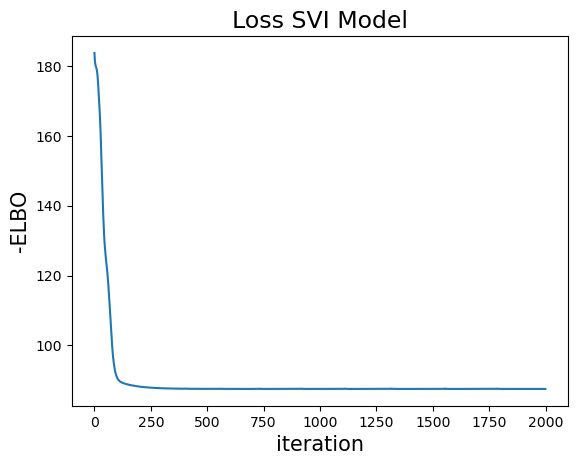

In [17]:
plt.plot(elbo)
plt.xlabel("iteration", fontsize=15)
plt.ylabel("-ELBO", fontsize=15)
plt.title("Loss SVI Model", fontsize=17)

In [18]:
post_predictive = pyro.infer.Predictive(model, guide=guide, num_samples=500)(x_test)
post_predictive

{'w1': tensor([[[[-0.2992,  0.1371, -0.1313, -0.1313, -0.3079],
           [-0.5554,  0.1658, -0.4341, -0.4341, -0.5742],
           [ 0.5564, -0.0656,  0.7224,  0.7224,  0.5722],
           [ 0.9012,  0.0627,  0.2961,  0.2961,  0.9305]]],
 
 
         [[[-0.2992,  0.1371, -0.1313, -0.1313, -0.3079],
           [-0.5554,  0.1658, -0.4341, -0.4341, -0.5742],
           [ 0.5564, -0.0656,  0.7224,  0.7224,  0.5722],
           [ 0.9012,  0.0627,  0.2961,  0.2961,  0.9305]]],
 
 
         [[[-0.2992,  0.1371, -0.1313, -0.1313, -0.3079],
           [-0.5554,  0.1658, -0.4341, -0.4341, -0.5742],
           [ 0.5564, -0.0656,  0.7224,  0.7224,  0.5722],
           [ 0.9012,  0.0627,  0.2961,  0.2961,  0.9305]]],
 
 
         ...,
 
 
         [[[-0.2992,  0.1371, -0.1313, -0.1313, -0.3079],
           [-0.5554,  0.1658, -0.4341, -0.4341, -0.5742],
           [ 0.5564, -0.0656,  0.7224,  0.7224,  0.5722],
           [ 0.9012,  0.0627,  0.2961,  0.2961,  0.9305]]],
 
 
         [[[-0.2992,  0.

In [19]:
model = Model()
nuts = pyro.infer.mcmc.NUTS(model, jit_compile=True)
mcmc = pyro.infer.mcmc.MCMC(nuts, num_samples=1000, warmup_steps=500, num_chains=1)
mcmc.run(x, y)

Warmup:   0%|                                                                                                          | 0/1500 [00:00, ?it/s]/Users/rcml/miniforge3/envs/pml22/lib/python3.11/site-packages/pyro/poutine/subsample_messenger.py:63: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  result = torch.tensor(0.0, device=self.device)
Sample: 100%|████████████████████████████████████████| 1500/1500 [05:32,  4.52it/s, step size=8.68e-03, acc. prob=0.954]                      


In [20]:
az_data = arviz.from_pyro(posterior=mcmc)
summary = arviz.summary(az_data)

summary

/Users/rcml/miniforge3/envs/pml22/lib/python3.11/site-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b1[0],-0.080,1.059,-1.943,2.045,0.057,0.040,347.0,581.0,NaN
b1[1],-0.113,1.080,-1.979,1.986,0.054,0.038,398.0,646.0,NaN
b1[2],-0.079,1.056,-2.154,1.792,0.049,0.035,464.0,661.0,NaN
b1[3],-0.093,1.105,-2.009,2.000,0.062,0.044,320.0,548.0,NaN
b1[4],0.029,1.063,-2.073,1.937,0.050,0.035,457.0,637.0,NaN
...,...,...,...,...,...,...,...,...,...
"w3[3, 1]",-0.020,1.339,-2.500,2.314,0.074,0.053,331.0,737.0,NaN
"w3[3, 2]",-0.000,1.370,-2.444,2.612,0.083,0.059,276.0,605.0,NaN
"w3[4, 0]",-0.004,1.377,-2.484,2.488,0.070,0.050,394.0,763.0,NaN
"w3[4, 1]",-0.018,1.328,-2.489,2.292,0.072,0.051,352.0,439.0,NaN


array([[<AxesSubplot: title={'center': 'b1'}>,
        <AxesSubplot: title={'center': 'b1'}>],
       [<AxesSubplot: title={'center': 'b2'}>,
        <AxesSubplot: title={'center': 'b2'}>],
       [<AxesSubplot: title={'center': 'b3'}>,
        <AxesSubplot: title={'center': 'b3'}>],
       [<AxesSubplot: title={'center': 'w1'}>,
        <AxesSubplot: title={'center': 'w1'}>],
       [<AxesSubplot: title={'center': 'w2'}>,
        <AxesSubplot: title={'center': 'w2'}>],
       [<AxesSubplot: title={'center': 'w3'}>,
        <AxesSubplot: title={'center': 'w3'}>]], dtype=object)

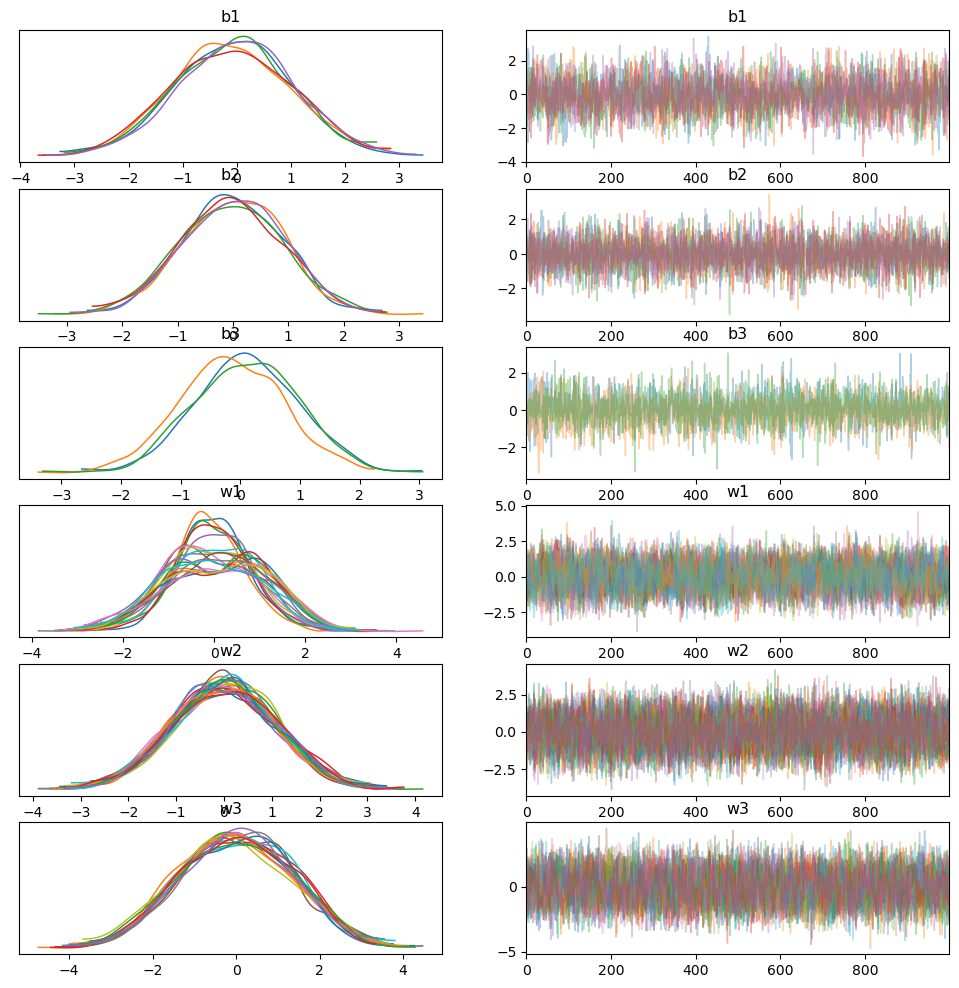

In [21]:
arviz.plot_trace(az_data)

/Users/rcml/miniforge3/envs/pml22/lib/python3.11/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (73) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<AxesSubplot: title={'center': 'b1\n0'}>,
        <AxesSubplot: title={'center': 'b1\n1'}>,
        <AxesSubplot: title={'center': 'b1\n2'}>,
        <AxesSubplot: title={'center': 'b1\n3'}>],
       [<AxesSubplot: title={'center': 'b1\n4'}>,
        <AxesSubplot: title={'center': 'b2\n0'}>,
        <AxesSubplot: title={'center': 'b2\n1'}>,
        <AxesSubplot: title={'center': 'b2\n2'}>],
       [<AxesSubplot: title={'center': 'b2\n3'}>,
        <AxesSubplot: title={'center': 'b2\n4'}>,
        <AxesSubplot: title={'center': 'b3\n0'}>,
        <AxesSubplot: title={'center': 'b3\n1'}>],
       [<AxesSubplot: title={'center': 'b3\n2'}>,
        <AxesSubplot: title={'center': 'w1\n0, 0'}>,
        <AxesSubplot: title={'center': 'w1\n0, 1'}>,
        <AxesSubplot: title={'center': 'w1\n0, 2'}>],
       [<AxesSubplot: title={'center': 'w1\n0, 3'}>,
        <AxesSubplot: title={'center': 'w1\n0, 4'}>,
        <AxesSubplot: title={'center': 'w1\n1, 0'}>,
        <AxesSubplot: title=

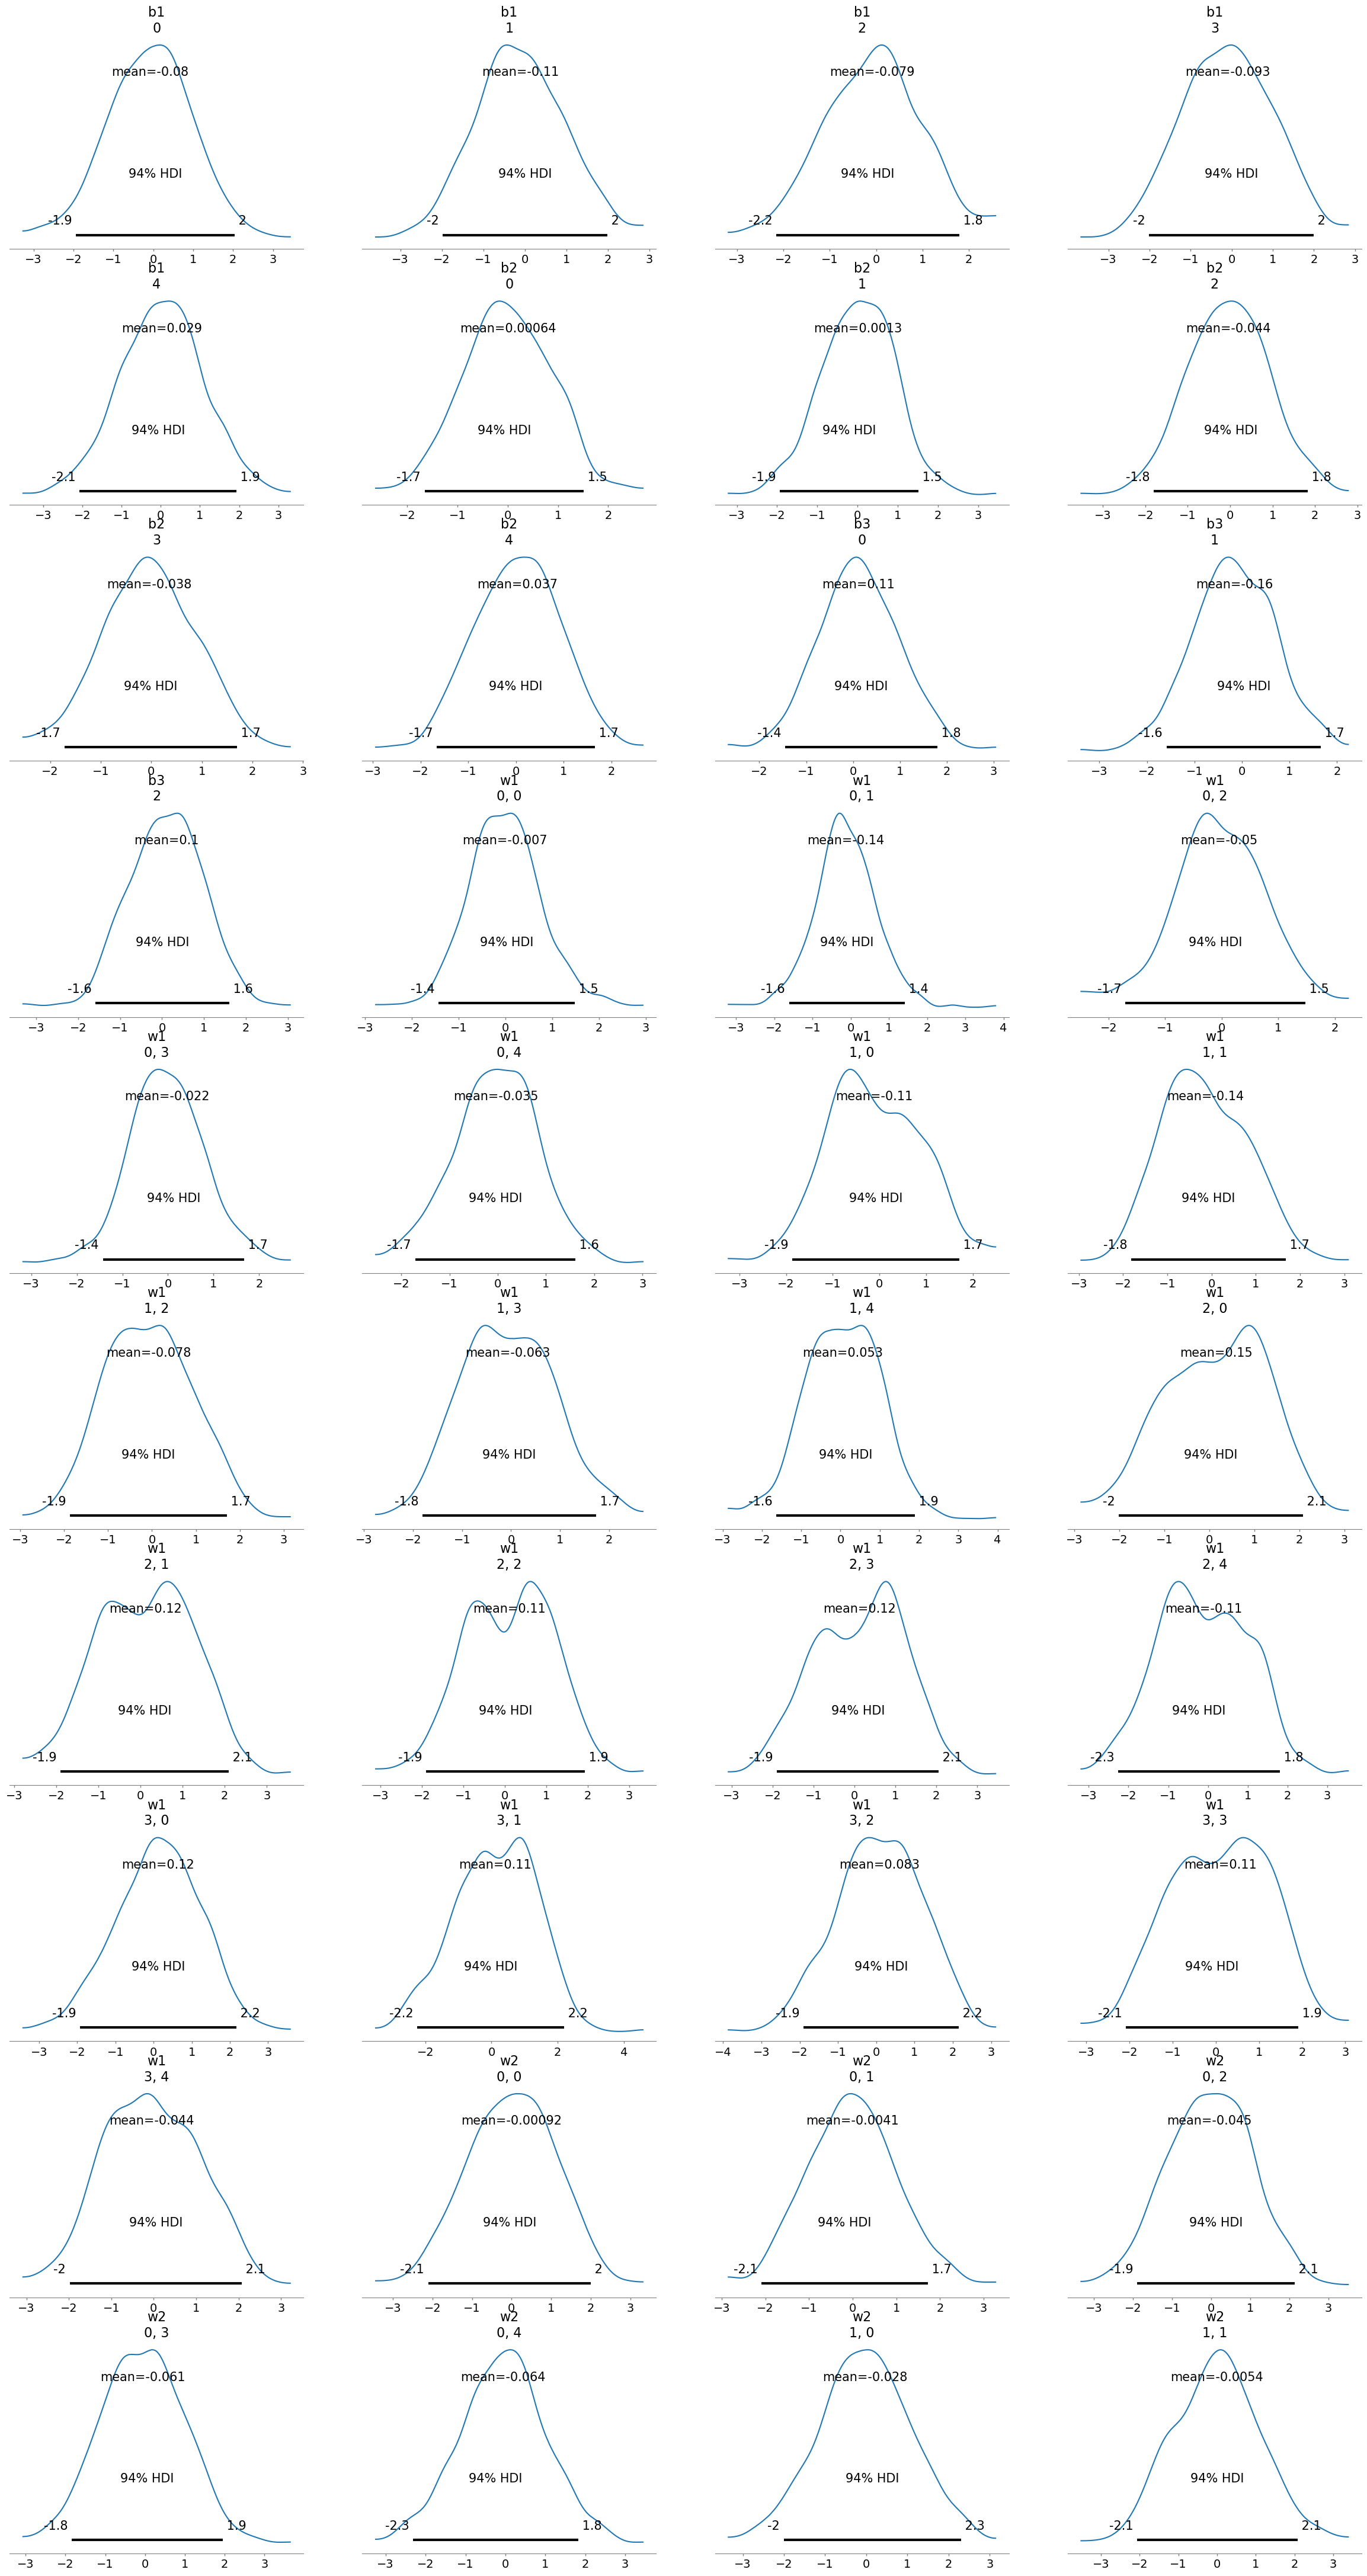

In [22]:
arviz.plot_posterior(az_data)

We can see that the majority of parameters have converged. The fit is OK.

###  Task 2) Difference in Posterior Representation of SVI and NUTS
SVI fits approximate $q(x, \theta)$ via a guide, which is optimized against observations using the ELBO and Adam optimizer. Whereas NUTS is a sampler (specifically a sampler kernel) for a MCMC algorithm. The MCMC object gives us a fitted posterior approximate from accepted samples after the sampling routine has terminated.

For details see https://pyro4ci.readthedocs.io/en/latest/mcmc.html

### Task 3) Advantages and Disadvantages of SVI and NUTS
Advantage NUTS: the fitted posterior from a MCMC routine using a NUT-sampler have some exactness guarantees, whereas SVI gives an approximation from a surrogate distribution (, and can have the tendency to underestimate the fitted variance).
Advantage SVI: the SVI algorithm scales to larger data-sets through amortized inference. MCMC sampling does not scale well to larger datsets, e.g. for HMC we get $\mathcal{O}(N^{\frac{5}{4}})$ (see https://arxiv.org/pdf/1206.1901.pdf)


### Task 4) Which Methods makes more sense and why
MCMC with NUTS makes more sense. No guide required, and data-set is sufficiently small to make sampling and MCMC posterior computation feasible.